# Install Pyspark

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .getOrCreate()

spark

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,151 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Pa

# Agenda


▶ Shared Variables

    ▶ Broadcast Variables

    ▶ Accumulators

▶ Shuffle    

▶ coalesce Transformation

▶ saveAsTextFile

▶ Count

▶ CountByKey

▶ Join

# Shared Variables in PySpark


In PySpark, when performing distributed computations, variables used within tasks are sent to the different nodes in the cluster. However, sometimes we need to share variables across multiple tasks or nodes, which is where Shared Variables come into play.

Types of Shared Variables

PySpark provides two types of shared variables:

<h1>Broadcast Variables</h1>

<h1>Accumulators</h1>

1. Broadcast Variables


What are Broadcast Variables?

Broadcast variables allow you to efficiently distribute large read-only datasets across all nodes.

Instead of sending a copy of the data to each task, PySpark sends a copy to each node, which is then shared across tasks on that node. This reduces the overhead of data transfer and improves performance.
Use Case:

Commonly used when you have a large lookup table that needs to be used across different tasks.


2. Accumulators

What are Accumulators?

Accumulators are variables that are only “added” to through associative and commutative operations and can be used to implement counters (like summing values).

They are useful for counting events (e.g., the number of errors seen in RDD elements) or for sums that can be safely accumulated in a distributed environment.
Use Case:

Commonly used for keeping track of metrics during job execution, like counting the number of processed records.



# Shuffle

Overview:

In PySpark, a shuffle refers to the process of redistributing data across the cluster, which is required when operations depend on grouping, joining, or aggregating data across partitions.

Shuffle operations are expensive because they involve disk I/O, data serialization, and network communication.

Common Operations that Trigger Shuffles:

groupByKey() and reduceByKey(): Grouping or reducing operations on a key will cause data to be shuffled across the cluster.

join(): Joining two RDDs or DataFrames based on a key triggers a shuffle to align the corresponding keys.

distinct() and repartition(): These operations also require shuffling data across partitions.

In [ ]:
from pyspark import SparkContext


# Sample data
data = ["apple banana", "banana apple", "apple orange", "orange banana"]

# Create an RDD
rdd = spark.sparkContext.parallelize(data)

# Split each line into words
words_rdd = rdd.flatMap(lambda line: line.split(" "))

# Create key-value pairs (word, 1)
word_pairs = words_rdd.map(lambda word: (word, 1))

# Count the occurrences of each word using reduceByKey (shuffle occurs here)
word_counts = word_pairs.reduceByKey(lambda a, b: a + b)

# Collect and print the results
print(word_counts.collect())


[('apple', 3), ('banana', 3), ('orange', 2)]


In [ ]:
# Broacdcast Practicle


data = ["hello world","hello spark","hello broadcast"," broadcast with spark","the","in","i","you","this","this","this is this this is this i and you know this is this"]
boringwords = ["the","in","i","you","this","is"]
broadcasted_boringwords = spark.sparkContext.broadcast(boringwords)
rdd = spark.sparkContext.parallelize(data)
#rdd.collect()
rdd1=rdd.flatMap(lambda x:x.split(" "))
rdd2=rdd1.filter(lambda x: x not in broadcasted_boringwords.value)
rdd2.collect()
#
rdd3=rdd2.map(lambda x:(x,1))
rdd4=rdd3.reduceByKey(lambda x,y:x+y)
rdd4.collect()



[('hello', 3),
 ('world', 1),
 ('', 1),
 ('with', 1),
 ('and', 1),
 ('spark', 2),
 ('broadcast', 2),
 ('know', 1)]

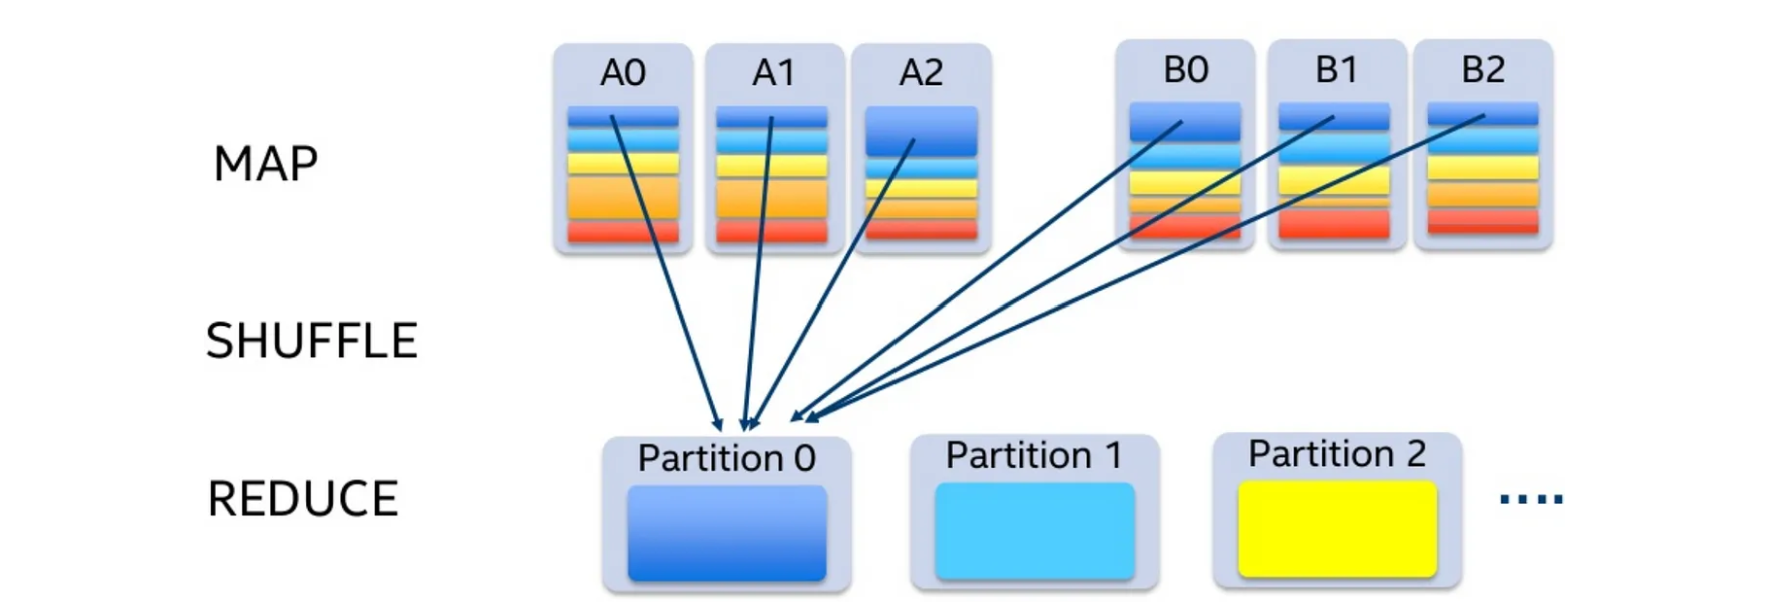

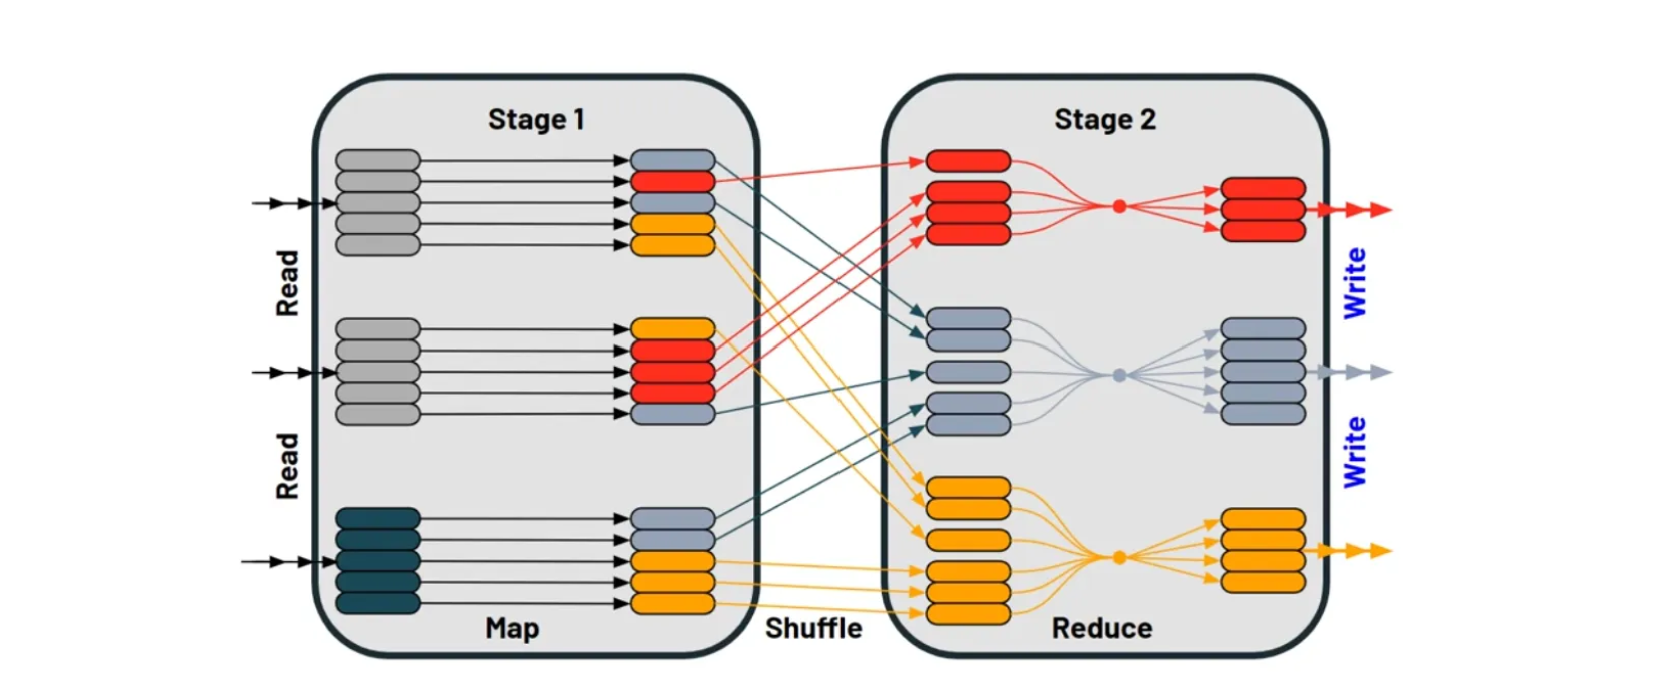

In [ ]:
# practical for Accumulator

sc = spark.sparkContext
numbers =[1,2,3,4,5,5,6,7,8,9,10]


rdd=spark.sparkContext.parallelize(numbers)

# Initialize an accumulator

evenNumberAccumulator = sc.accumulator(0)

def even_number(number):
  if number % 2 == 0:
    evenNumberAccumulator.add(1)
  return number

rdd.map(even_number).collect()

print(f"Number of even numbers: {evenNumberAccumulator.value}")


Number of even numbers: 5


# Count

1. Understanding count Transformation

The count transformation in PySpark is used to count the number of elements in an RDD. It's a straightforward action that returns a single integer representing the number of records in the dataset.

Key Points:

count is an action, not a transformation. This means it triggers the actual computation and returns the result.

It’s commonly used when you want to know the size of your dataset or to validate that a transformation has produced the expected number of records.

In [ ]:
from pyspark import SparkContext

# Initialize a SparkContext
sc = spark.sparkContext

# Create an RDD
numbers_rdd = sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Count the number of elements in the RDD
count_result = numbers_rdd.count()

print(f"Number of elements in the RDD: {count_result}")

Number of elements in the RDD: 10


# countByKey

The countByKey transformation is used on an RDD containing key-value pairs (i.e., (K, V) pairs).

It counts the number of occurrences for each key and returns the result as a dictionary where keys are the unique keys from the RDD and values are the count of occurrences.

Key Points:

countByKey is an action, meaning it triggers the actual computation.
It’s useful when you want to aggregate or summarize data based on keys.

In [ ]:
# Create an RDD of key-value pairs

pairs_rdd = sc.parallelize([('a', 1), ('b', 1), ('a', 1), ('c', 1), ('b', 1), ('b', 1)])

# Count the occurrences of each key
count_by_key_result = pairs_rdd.countByKey()

print(f"Count by key: {count_by_key_result}")


Count by key: defaultdict(<class 'int'>, {'a': 2, 'b': 3, 'c': 1})


Comparison between count and countByKey:

count: Returns the total number of elements in the entire RDD.

countByKey: Returns the count of elements for each unique key in an RDD of key-value pairs.

In [ ]:
logs_rdd = sc.parallelize([
    ('user1', 'login'),
    ('user2', 'click'),
    ('user1', 'logout'),
    ('user3', 'login'),
    ('user2', 'purchase'),
    ('user1', 'click')
])

total_logs =logs_rdd.count()
print(f"Total number of logs:{total_logs}")

logs_per_user =logs_rdd.countByKey()
print(f"Number of logs per user: {logs_per_user}")


Total number of logs:6
Number of logs per user: defaultdict(<class 'int'>, {'user1': 3, 'user2': 2, 'user3': 1})


In [ ]:
Shuffle
Broadcast
Accumulator
count
countbykey